# **Lab: End-to-End RAG Implementation with AWS Bedrock and API Integration**

## Introduction:
In this lab, we will walk through the process of building an **End-to-End Retrieval-Augmented Generation (RAG)** system using **AWS Bedrock** and **API integration**. RAG combines information retrieval and generative AI to produce more accurate and up-to-date responses. We will implement a scalable architecture where we retrieve relevant documents from a knowledge base and use them to augment language model responses.

You will learn how to:
- Integrate **AWS Bedrock** for retrieving foundation models.
- Use **FAISS (Facebook AI Similarity Search)** for efficient vector-based document retrieval.
- Generate semantic search results and integrate with **Claude**, a language model, for generating responses.
- Implement the full RAG pipeline, from retrieving documents to generating contextually accurate answers via an API.

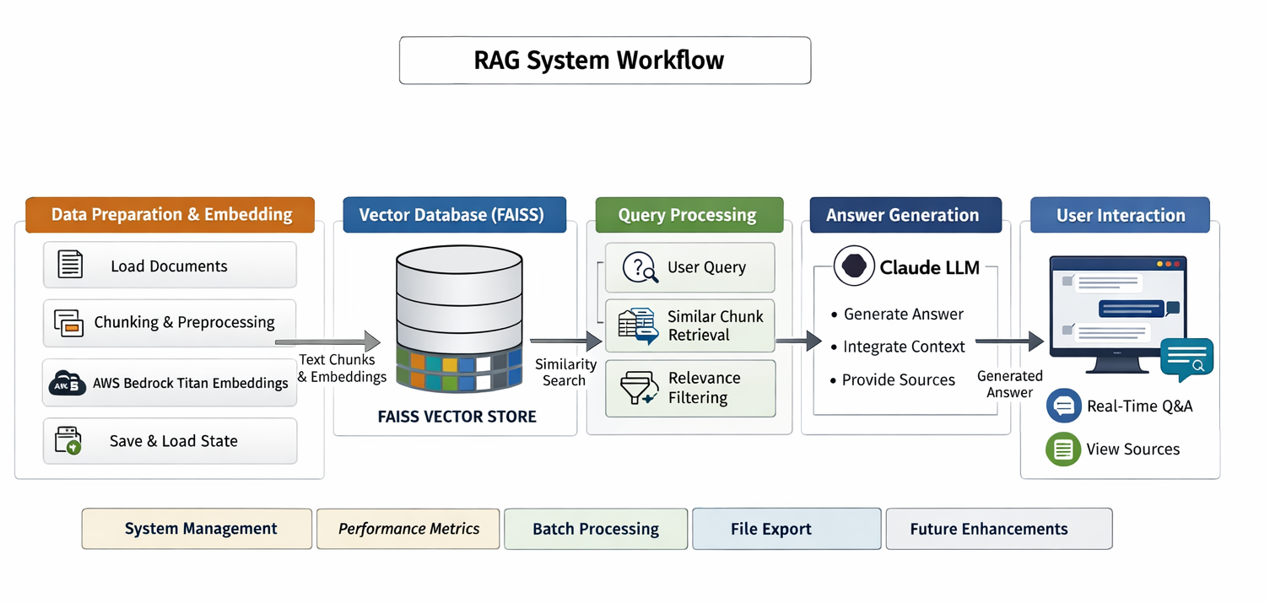

## Scenario:
You are working as an AI Engineer at a technology company that provides automated solutions for customer service. Your team is tasked with building a conversational AI system capable of answering client queries using real-time knowledge from a set of documents.

 You decide to implement a **RAG system** to enhance the accuracy and contextuality of the AI responses. This system will retrieve relevant documents from an internal knowledge base and use that information to generate precise answers to customer inquiries.

In this lab, you will:
1. Retrieve and chunk documents into smaller pieces for effective embedding.
2. Generate embeddings using **AWS Bedrock's Titan model**.
3. Create a **FAISS vector database** for efficient document retrieval based on query similarity.
4. Implement an **API** that combines the retrieved documents with a generative model (Claude) to create responses for user queries.




## Description:
In this lab, you'll implement an **End-to-End RAG system** using **AWS Bedrock** and **FAISS**. You'll retrieve documents from an internal knowledge base, generate vector embeddings using Bedrock, and create a vector store with **FAISS**.

Afterward, you'll integrate an API that uses **Claude** to generate responses based on the augmented context. This end-to-end solution will provide real-time, contextually accurate answers to user queries.

This lab covers:
- Document loading, chunking, and embedding generation
- Setting up FAISS for efficient vector search
- Implementing RAG with API for real-time AI responses

By the end of the lab, you’ll have a working prototype of a RAG system that combines retrieval-based techniques with generative AI, using AWS services and an API-based approach.

In [ ]:
# Import 'os' module for directory and file operations
import os

# Create the 'rag-project/data' directory, no error if it already exists
os.makedirs('rag-project/data', exist_ok=True)
print("✅ Folders created!")  # Confirm directories are created

# Get and display the current working directory
print("\nCurrent directory:", os.getcwd())

# Show the folder structure under 'rag-project'
print("\nFolder structure:")
# Walk through the directory and subdirectories
for root, dirs, files in os.walk('rag-project'):
    # Calculate the depth of the directory
    level = root.replace('rag-project', '').count(os.sep)
    # Add spaces for indentation based on depth
    indent = ' ' * 2 * level
    # Print folder name with indentation
    print(f'{indent}{os.path.basename(root)}/')


#### Code Explanation:

**Importing `os`:**   The `os` module is used for interacting with directories and files in Python. It provides a portable way to use operating system-dependent functionality.

**Creating Directories:**  This creates the `rag-project/data` folder. If the directory already exists, no error is raised due to the `exist_ok=True` parameter.

**Getting the Current Directory:**  The function `os.getcwd()` returns the current working directory, which is the directory from which the script is being executed.

**Exploring Folder Structure:**  The `os.walk()` function is used to loop through directories and subdirectories. It prints the folder structure with indentation based on the level of depth in the hierarchy. Each directory is printed in a formatted way where the depth of the directory is represented by indentation.


In [ ]:
# Step 1: Install all required packages

# Installation might take 3-5 minutes depending on the connection.

%time  # Measure the time it takes to run this cell
# Install the required packages quietly (no output shown)
!pip install -q langchain==0.1.0
!pip install -q langchain-community==0.0.20
!pip install -q faiss-cpu==1.7.4
!pip install -q pypdf==4.0.0
!pip install -q wikipedia==1.4.0
!pip install -q youtube-search-python==1.6.6

# Confirm successful installation of all packages
print("✅ All packages installed successfully!")


#### Code Explanation:

**`%time`:**  Measures and displays the execution time for this cell.

**Installing Packages:**  The `!pip install -q` command installs Python packages without showing verbose output. The following packages are essential for the project:

- **langchain and langchain-community:** Libraries for working with language models.
- **faiss-cpu:** For similarity search using FAISS.
- **pypdf:** For handling PDF files.
- **wikipedia:** For querying Wikipedia.
- **youtube-search-python:** For searching YouTube content.

**Confirmation Message:**  Prints a success message once all packages are installed.


In [ ]:
# Step 2: Create sample document

# Define the content for the sample document
sample_content = """
📘 1. What is AWS (Amazon Web Services)?
Amazon Web Services (AWS) is a comprehensive cloud computing platform offered by Amazon that provides a broad set of on demand cloud services — including compute, storage, databases, analytics, networking, machine learning, security, and more — to individuals, startups, enterprises, and governments. AWS allows you to access scalable computing power and storage over the internet, with a pay as you go pricing model.
🔹 Key Characteristics
•	Cloud Computing Platform: Enables computing without owning physical servers.
•	Global Infrastructure: AWS has multiple regions and availability zones around the world to ensure reliability and low latency.
•	240+ Services: Including compute (EC2), storage (S3), databases (RDS), AI/ML, security, developer tools, and more.
•	Security & Compliance: Enterprise grade security, encryption, identity management, and compliance offerings.
🧠 Benefits
•	Cost effective: No upfront hardware costs; pay only for what you use.
•	Scalable & Flexible: Scale up/down resources based on demand.
•	Reliable: High availability and fault tolerance.
🔗 Official Info: https://aws.amazon.com/what-is-aws/
🔗 AWS Documentation Overview: https://docs.aws.amazon.com/whitepapers/latest/aws-overview/introduction.html
________________________________________
🤖 2. What is AWS Bedrock?
AWS Bedrock is a fully managed service from AWS that lets developers build generative AI applications using a choice of high performance foundation models (FMs) from multiple providers — such as Anthropic, AI21 Labs, Cohere, Stability AI, Meta, and Amazon — through a single API.
🧠 Key Features
•	Model Choice: Access and experiment with models like Claude, Titan, Jurassic, and Stable Diffusion in one place (no vendor lock in).
•	Customizations: Fine tune models with your own data using techniques like instruction tuning.
•	Secure & Scalable: Enterprise grade security and serverless deployment with no infrastructure to manage.
•	Integration: Works with other AWS services (S3, IAM, VPC).
Bedrock simplifies building generative AI capabilities such as chatbots, summarization tools, and document understanding, while handling provisioning, scaling, model selection, and security.
🔗 Official AWS Bedrock Page: https://aws.amazon.com/bedrock/
________________________________________
🧠 3. What is Amazon SageMaker?
Amazon SageMaker (recently branded SageMaker AI) is AWS’s fully managed machine learning (ML) service that enables developers and data scientists to build, train, and deploy machine learning models at scale.
🔹 What SageMaker Provides
•	Data Preparation & Features: Tools like Data Wrangler for data cleaning and exploration.
•	Notebooks & IDE: Hosted Jupyter notebooks for data science workflows.
•	Model Training & Tuning: Train models using built in or custom algorithms with automatic hyperparameter optimization.
•	Deployment & Monitoring: Deploy models as real time endpoints with monitoring.
📌 Why Use SageMaker?
•	Reduces complexity of ML workflows.
•	Integrates with AWS ecosystem (S3, Lambda, CloudWatch).
•	Supports popular frameworks (TensorFlow, PyTorch).
🔗 Official SageMaker Info: https://aws.amazon.com/sagemaker/
________________________________________
📘 4. What is RAG (Retrieval Augmented Generation)?
Retrieval Augmented Generation (RAG) is an advanced AI technique that combines information retrieval with generative models to produce more accurate, up to date, and context aware responses. Instead of generating text solely from the model’s internal learned knowledge, RAG systems retrieve relevant documents or data from an external knowledge base and augment the query with that context before generating the answer.
🧠 How RAG Works
1.	Retrieve relevant documents or passages based on semantic similarity to the user query.
2.	Augment the original prompt with the retrieved data.
3.	Generate the response using a language model with the augmented prompt.
📌 Why RAG?
✔ Produces responses grounded in real, specific, domain relevant data.
✔ Fills gaps in model knowledge with up to date information.
✔ Improves accuracy and factual correctness.
🔗 AWS RAG Docs (SageMaker): https://docs.aws.amazon.com/sagemaker/latest/dg/jumpstart-foundation-models-customize-rag.html
________________________________________
🎓 5. What is K21 Academy?
K21 Academy is a technology training and upskilling platform based in India that offers job oriented courses focused on cloud computing, AI/ML, DevOps, data engineering, and related technologies. It combines instructor led training, hands on labs, projects, and placement assistance to help learners prepare for real world roles.
🔹 Highlights
•	Offers cloud & AI/ML bootcamps, including AWS, Azure, Google Cloud, and DevOps programs.
•	Provides hands on practice with real projects and labs.
•	Career support, resume prep, interview guidance, and community access.
🔗 Official Site: https://k21academy.com/
________________________________________
📚 Summary Table
Topic	Definition	Official Link
AWS	Cloud computing platform with over 240 services, scalable, secure, pay as you go. 	https://aws.amazon.com/what-is-aws/
AWS Bedrock	Managed generative AI service with access to multiple foundation models.	https://aws.amazon.com/bedrock/
Amazon SageMaker	Managed machine learning platform for building, training, and deploying models. 	https://aws.amazon.com/sagemaker/
RAG	Technique combining retrieval from knowledge bases with generative AI. 	https://docs.aws.amazon.com/sagemaker/latest/dg/jumpstart-foundation-models-customize-rag.html
K21 Academy	Tech training platform offering cloud, AI/ML, and DevOps programs.
"""

# Save the content to a text file
file_path = 'rag-project/data/aws_rag.txt'

# Open the file in write mode and save the content
with open(file_path, 'w', encoding='utf-8') as f:
    f.write(sample_content)

# Confirm the file was created and print file details
print(f"✅ Document created: {file_path}")
print(f"📊 Document size: {len(sample_content)} characters")
print(f"📄 Approximate words: {len(sample_content.split())} words")

# Verify if the file exists
import os
if os.path.exists(file_path):
    print(f"✅ File verified at: {file_path}")
else:
    print("❌ Error: File not created")


#### Code Explanation:

**Document Content:**  The `sample_content` variable holds the full content with all the required information, including sections about AWS, AWS Bedrock, Amazon SageMaker, RAG, and K21 Academy.

**Saving the File:**  The file is saved as `aws_rag.txt` in the `rag-project/data/` folder.

**Verifying File Creation:**  After the document is saved, the script checks if the file exists and confirms it by printing the file path and size.

This code should successfully create and save the document in your project folder. Let me know if you need further help!


In [ ]:
# Step 3: List all files in data folder

# Import os module to interact with the operating system (for file handling)
import os

# Display message indicating that the list of files is being shown
print("📁 Files in data folder:")
print("-" * 50)

# Define the path to the 'data' folder
data_folder = 'rag-project/data'

# Check if the 'data' folder exists
if os.path.exists(data_folder):
    # List all files in the folder
    files = os.listdir(data_folder)

    # If the folder contains files, list each file and its size
    if files:
        for file in files:
            file_path = os.path.join(data_folder, file)  # Full file path
            size = os.path.getsize(file_path)  # Get file size in bytes
            print(f"  📄 {file} ({size:,} bytes)")  # Print file name and size
    else:
        # If the folder is empty, notify the user
        print("  (empty)")
else:
    # If the 'data' folder doesn't exist, notify the user
    print("  ❌ Data folder not found")


#### Code Explanation:

**`os.path.exists(data_folder)`:**  Checks if the data folder exists.

**`os.listdir(data_folder)`:**  Lists all files in the data folder.

**`os.path.getsize(file_path)`:**  Retrieves the size of each file in bytes.

**Displaying File Information:**  For each file, its name and size are printed. If the folder is empty or doesn't exist, an appropriate message is displayed.

This script will list all the files in the `rag-project/data/` folder, along with their sizes. Let me know if you'd like any further modifications!


In [ ]:
# Step 4: Import libraries and setup AWS Bedrock

# Import necessary libraries
import boto3  # AWS SDK for Python
import json   # For JSON data handling
import numpy as np  # For handling numerical data
from typing import List, Dict  # For type annotations
import warnings  # To filter warnings
warnings.filterwarnings('ignore')  # Ignore unnecessary warnings

# Display status message
print("🔧 Setting up AWS Bedrock...")

# Initialize the AWS Bedrock Runtime client (No credentials required if using SageMaker's role)
bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # Specify your AWS region
)

# Initialize agent runtime client for Bedrock
bedrock_agent_runtime = boto3.client(
    service_name='bedrock-agent-runtime',
    region_name='us-east-1'
)

# Confirm that the clients are initialized
print("✅ Bedrock clients initialized!")

# Test the connection to AWS Bedrock
try:
    bedrock = boto3.client('bedrock', region_name='us-east-1')  # Connect to Bedrock
    response = bedrock.list_foundation_models()  # List available foundation models
    model_count = len(response.get('modelSummaries', []))  # Get the count of available models
    print(f"✅ Successfully connected to Bedrock!")
    print(f"📊 Available models: {model_count}")

    # Check access to required models
    print("\n🎯 Checking access to required models...")
    required_models = [
        'amazon.titan-embed-text-v1',
        'anthropic.claude-3-sonnet-20240229-v1:0'
    ]

    # Loop through the required models and check access
    for model_id in required_models:
        try:
            model_info = bedrock.get_foundation_model(modelIdentifier=model_id)  # Try fetching model info
            print(f"  ✅ {model_id}")
        except:
            print(f"  ❌ {model_id} - NOT ACCESSIBLE")
            print(f"     Please enable this model in the AWS Bedrock Console")

except Exception as e:
    # Handle errors and provide troubleshooting steps
    print(f"❌ Error connecting to Bedrock: {e}")
    print("\n🔍 Troubleshooting:")
    print("  1. Check if Bedrock models are enabled in the AWS Console")
    print("  2. Verify IAM role has AmazonBedrockFullAccess policy")
    print("  3. Confirm you're in a supported region (us-east-1, us-west-2)")


#### Code Explanation:

**Libraries:**  Import necessary libraries (`boto3`, `json`, `numpy`, `warnings`) to interact with AWS and handle data.

**Initialize Bedrock Clients:**  The `bedrock_runtime` and `bedrock_agent_runtime` clients are initialized to interact with AWS Bedrock services. You only need to specify the AWS region when creating these clients.

**Test Connection:**  The code tests the connection by listing available foundation models in AWS Bedrock and checking if required models (like Titan and Claude) are accessible.

**Error Handling:**  If the connection fails, the script prints troubleshooting steps to help you resolve any issues related to Bedrock access, IAM roles, or region settings.


In [ ]:
# Step 5: Load documents

# Import necessary modules for document loading
from langchain.document_loaders import TextLoader
import os  # For file and directory operations

# Display message
print("📄 Loading documents...")

# Define the file path to the document
file_path = 'rag-project/data/aws_rag.txt'

# Check if the file exists
if not os.path.exists(file_path):
    # If the file doesn't exist, notify the user and display available files
    print(f"❌ File not found: {file_path}")
    print("\nAvailable files:")
    print(os.listdir('rag-project/data'))  # List all files in the 'data' folder
else:
    # If the file exists, load the document using TextLoader
    loader = TextLoader(file_path, encoding='utf-8')
    documents = loader.load()  # Load the content of the document

    # Print confirmation and document details
    print(f"✅ Loaded {len(documents)} document(s)")
    print(f"📊 Total characters: {sum(len(doc.page_content) for doc in documents):,}")  # Show total character count

    # Display the first 200 characters of the first document as a preview
    print(f"\n📝 First 200 characters:")
    print("-" * 60)
    print(documents[0].page_content[:200] + "...")
    print("-" * 60)

#### Code Explanation:

**Importing Libraries:**  `TextLoader` from `langchain.document_loaders` is used to load text documents, and `os` is used for file path and directory operations.

**Checking File Existence:**  The code first checks if the file at `file_path` exists. If it doesn't, it lists the available files in the directory to help you locate the file.

**Loading the Document:**  If the file exists, the content of the document is loaded into a `documents` list using `TextLoader`. The content is then processed, and basic statistics such as the number of characters and the first 200 characters are displayed.

**Preview:**  The first 200 characters of the document are displayed as a preview, providing insight into the content without displaying the entire document.


In [ ]:
# Step 6: Chunk documents into smaller pieces

# Import necessary module for text splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Display message
print("✂️ Chunking documents...")

# Create a text splitter to break the document into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,           # Maximum size of each chunk in characters
    chunk_overlap=50,         # Number of characters that overlap between chunks to maintain context
    length_function=len,      # Function to calculate the length of text (default is len)
    separators=["\n\n", "\n", ". ", " ", ""]  # List of separators to break text
)

# Split the document into chunks
chunks = text_splitter.split_documents(documents)

# Show the number of chunks created and their average size
print(f"✅ Created {len(chunks)} chunks")
print(f"📊 Average chunk size: {sum(len(c.page_content) for c in chunks) // len(chunks)} characters")

# Display sample chunks for preview
print(f"\n📝 Sample chunks:")
print("=" * 60)
for i, chunk in enumerate(chunks[:3], 1):  # Show first 3 chunks
    print(f"\nChunk {i} ({len(chunk.page_content)} chars):")
    print("-" * 60)
    print(chunk.page_content)  # Print the chunk content
    print("-" * 60)

# Store the text content of chunks for embedding later
chunk_texts = [chunk.page_content for chunk in chunks]
print(f"\n✅ Stored {len(chunk_texts)} chunks for embedding")


#### Code Explanation:

**`text_splitter`:**  This is used to divide the document into smaller, manageable pieces (chunks). You can adjust the chunk size (500 characters) and the overlap (50 characters) to ensure context is preserved across chunks.

**Chunking:**  The document is split into chunks based on the provided separators (`\n\n`, `\n`, `.`, etc.), ensuring logical splits where appropriate, which helps maintain the structure and context of the original document.

**Statistics:**  The script prints the number of chunks and their average size, giving an overview of how the document was divided.

**Sample Chunks:**  It shows the first 3 chunks as samples to give you an idea of how the text is split and ensure the splitting logic is working correctly.

**Storing Chunks:**  The content of each chunk is stored in `chunk_texts` for later processing, such as generating embeddings or creating a FAISS index.

This script efficiently handles large documents by splitting them into smaller chunks, making them easier to process for tasks like embedding generation or semantic search.


In [ ]:
# Step 7: Generate vector embeddings using Bedrock Titan

# Display status messages
print("🔢 Generating embeddings with Bedrock Titan...")
print("⏳ This may take 30-60 seconds...\n")

# Function to generate embeddings using AWS Bedrock's Titan model
def get_embedding(text: str) -> List[float]:
    """Generate embedding for text using Bedrock Titan"""
    try:
        # Call Bedrock API to generate embedding for the input text
        response = bedrock_runtime.invoke_model(
            modelId='amazon.titan-embed-text-v1',  # Specify the model ID
            contentType='application/json',
            accept='application/json',
            body=json.dumps({"inputText": text})  # Pass the text as input
        )

        # Parse the response and extract the embedding
        response_body = json.loads(response['body'].read())
        return response_body['embedding']

    except Exception as e:
        print(f"❌ Error generating embedding: {e}")
        return None

# Generate embeddings for all chunks in the document
embeddings = []
total_chunks = len(chunk_texts)

# Loop through each chunk to generate embeddings
for i, text in enumerate(chunk_texts, 1):
    # Show progress every 5 chunks or at the end
    if i % 5 == 0 or i == total_chunks:
        print(f"  Processing {i}/{total_chunks} chunks... ({i*100//total_chunks}%)")

    embedding = get_embedding(text)
    if embedding:
        embeddings.append(embedding)  # Append the generated embedding
    else:
        print(f"  ⚠️ Failed to generate embedding for chunk {i}")

# Final confirmation and embedding details
print(f"\n✅ Successfully generated {len(embeddings)} embeddings")
print(f"📏 Embedding dimension: {len(embeddings[0])}")  # Display the dimension of each embedding
print(f"💾 Total embedding data: {len(embeddings) * len(embeddings[0]) * 4 / 1024:.2f} KB")  # Estimate the total size of the embeddings


#### Code Explanation:

**Status Messages:**  
The code prints status messages to inform you that the embedding generation process is starting and how long it may take (30-60 seconds).

**`get_embedding(text: str) -> List[float]`:**  This function generates embeddings for the input text using AWS Bedrock's Titan model. The process involves:
- Making a call to the `bedrock_runtime.invoke_model()` method with the specified `modelId` (`amazon.titan-embed-text-v1`).
- Sending the input text as JSON in the request body.
- Parsing the response to extract the generated embedding.

**Looping Through Chunks:**  The script loops through each chunk of text (from `chunk_texts`) and generates embeddings for them using the `get_embedding` function. It prints progress every 5 chunks or when the last chunk is processed.

**Progress and Error Handling:**  During each loop iteration, the script displays progress information (such as the percentage of chunks processed). If an error occurs during embedding generation, the script prints an error message and skips that chunk.

**Final Confirmation:**  After processing all the chunks, the script displays the following:
- The total number of successfully generated embeddings.
- The dimension of the embeddings (the size of each vector).
- The estimated size of the total embedding data in kilobytes.

This script leverages AWS Bedrock’s Titan model to generate embeddings for text chunks, which are crucial for tasks like semantic search or similarity analysis.


In [ ]:
# Step 8: Create FAISS vector database with metadata (including links)

# Import necessary libraries
import faiss  # For efficient similarity search
import numpy as np  # For numerical operations
import re  # For regular expressions to extract links

# Display message
print("🗄️ Creating FAISS vector store with metadata...\n")

# Function to extract URLs from the text
def extract_links(text):
    """Extract URLs from text using regex"""
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    links = re.findall(url_pattern, text)  # Find all matching URLs
    return links

# Convert embeddings to numpy array (required for FAISS)
embeddings_array = np.array(embeddings).astype('float32')
print(f"📊 Embedding array shape: {embeddings_array.shape}")
print(f"   - Number of vectors: {embeddings_array.shape[0]}")
print(f"   - Vector dimension: {embeddings_array.shape[1]}")

# Get the embedding vector dimension
dimension = embeddings_array.shape[1]

# Create FAISS index (L2 distance = Euclidean distance)
index = faiss.IndexFlatL2(dimension)

# Add embeddings to the FAISS index
index.add(embeddings_array)

print(f"\n✅ Vector store created successfully!")
print(f"   - Index type: L2 (Euclidean distance)")
print(f"   - Total vectors indexed: {index.ntotal}")

# Create mapping for chunks with metadata (text and links)
doc_store = {}
for i in range(len(chunk_texts)):
    chunk_text = chunk_texts[i]  # Get the chunk's text
    links = extract_links(chunk_text)  # Extract links from the chunk text

    doc_store[i] = {  # Store chunk and its metadata
        'text': chunk_text,
        'links': links,
        'has_links': len(links) > 0  # Flag if the chunk contains links
    }

# Print statistics about link extraction
chunks_with_links = sum(1 for doc in doc_store.values() if doc['has_links'])
total_links = sum(len(doc['links']) for doc in doc_store.values())

print(f"\n📎 Link extraction summary:")
print(f"   - Chunks with links: {chunks_with_links}/{len(chunk_texts)}")
print(f"   - Total links found: {total_links}")

# Show sample chunks that contain links
print(f"\n🔍 Sample chunks with links:")
count = 0
for i, doc in doc_store.items():
    if doc['has_links'] and count < 3:  # Show the first 3 chunks with links
        print(f"\n   Chunk {i}:")
        print(f"   Text preview: {doc['text'][:100]}...")  # Preview of the chunk
        print(f"   Links: {doc['links']}")  # Display the extracted links
        count += 1

# Save the FAISS index to disk
index_path = 'rag-project/faiss_index.bin'
faiss.write_index(index, index_path)
print(f"\n💾 Index saved to: {index_path}")

# Save the document store (metadata with links) using pickle
import pickle
doc_store_path = 'rag-project/doc_store.pkl'
with open(doc_store_path, 'wb') as f:
    pickle.dump(doc_store, f)  # Save the document store as a binary file
print(f"💾 Document store with links saved to: {doc_store_path}")

# Verify the saved index and document store
loaded_index = faiss.read_index(index_path)
print(f"\n✅ Verified: Loaded index has {loaded_index.ntotal} vectors")

with open(doc_store_path, 'rb') as f:
    loaded_doc_store = pickle.load(f)
print(f"✅ Verified: Loaded doc store has {len(loaded_doc_store)} entries")


#### Code Explanation:

**Importing Libraries:**  
- **`faiss`:** Used for efficient similarity search by creating and querying vector databases.
- **`numpy`:** For numerical operations, particularly for handling arrays of embeddings.
- **`re`:** Used for regular expressions to extract URLs from the text.

**Creating FAISS Vector Store:**  The script creates a FAISS vector database with metadata, including links, for efficient similarity search. The process involves:
1. **Embedding Conversion:**  
   The embeddings generated in the previous cell are converted into a `numpy` array (required by FAISS).
2. **FAISS Index Creation:**  
   A FAISS index is created using the L2 (Euclidean) distance metric, which is used for comparing vectors.
3. **Adding Embeddings:**  
   The embeddings are added to the FAISS index for later search operations.

**Extracting Links from Text:**  The function `extract_links()` is used to extract URLs from each text chunk using regular expressions. If any links are found, they are stored in the document store.

**Document Store Creation:**  A `doc_store` is created to store metadata for each chunk, including:
- **Text:** The original chunk text.
- **Links:** The URLs extracted from the text.
- **has_links:** A flag indicating whether the chunk contains any links.

**Link Extraction Summary:**  
- The number of chunks containing links and the total number of links found across all chunks are displayed.
- Sample chunks with links are shown to provide insight into the extracted data.

**Saving the Index and Document Store:**  
- The FAISS index is saved to a file (`faiss_index.bin`).
- The document store (metadata with links) is saved using `pickle` to a file (`doc_store.pkl`).

**Verification:**  The saved FAISS index and document store are loaded back from disk to verify the integrity of the saved data, confirming that the index has the expected number of vectors and the document store contains the correct number of entries.


In [ ]:
# Step 9: Vector similarity search function

# Function to perform vector similarity search in the FAISS index
def search_similar_chunks(query: str, k: int = 3) -> List[Dict]:
    """
    Search for similar chunks using vector similarity

    Args:
        query: Search query text
        k: Number of top results to return

    Returns:
        List of dictionaries with chunk text, links, and similarity scores
    """
    # Display search query
    print(f"\n🔍 Searching for: '{query}'")
    print(f"📊 Retrieving top {k} results...\n")

    # Generate embedding for the query
    query_embedding = get_embedding(query)

    # If embedding generation fails, return empty result
    if query_embedding is None:
        print("❌ Failed to generate query embedding")
        return []

    # Convert query embedding to numpy array
    query_vector = np.array([query_embedding]).astype('float32')

    # Perform the search in the FAISS index
    distances, indices = index.search(query_vector, k)

    # Prepare and return results
    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0]), 1):
        similarity_score = 1 / (1 + float(dist))  # Convert distance to similarity score

        # Fetch the document details from doc_store
        doc = doc_store[int(idx)]

        # Store result information in a dictionary
        results.append({
            'rank': i,
            'index': int(idx),
            'text': doc['text'],
            'links': doc['links'],
            'has_links': doc['has_links'],
            'distance': float(dist),
            'similarity_score': similarity_score
        })

        # Print result preview and similarity score
        print(f"📌 Result {i} (Score: {similarity_score:.4f}, Distance: {dist:.4f})")
        print(f"   Text preview: {doc['text'][:100]}...")  # Show first 100 characters of text

        # If links are found in the document, display them
        if doc['has_links']:
            print(f"   🔗 Links found: {', '.join(doc['links'][:2])}")  # Show first 2 links
            if len(doc['links']) > 2:
                print(f"      ... and {len(doc['links']) - 2} more")  # Indicate more links

        print()

    return results

# Test the search function with a few sample queries
print("=" * 80)
print("🧪 TESTING VECTOR SEARCH")
print("=" * 80)

# List of test queries to search for
test_queries = [
    "What is AWS Bedrock?",
    "Explain RAG",
    "How do vector embeddings work?"
]

# Perform search for each query and display results
for query in test_queries:
    results = search_similar_chunks(query, k=2)  # Get top 2 results for each query
    print("-" * 80)

    # Optionally, display detailed results with links
    if results:
        print("\n📋 Detailed Results:")
        for result in results:
            print(f"\n   Rank {result['rank']}:")
            print(f"   Similarity: {result['similarity_score']:.4f}")
            if result['has_links']:
                print(f"   🔗 All Links:")
                for link in result['links']:
                    print(f"      • {link}")  # Print all links found in the document
        print()


#### Code Explanation:

**`search_similar_chunks(query: str, k: int = 3) -> List[Dict]`:**  
This function performs a vector similarity search in the FAISS index to find the most similar chunks to the input query.

- **Args:**
  - **`query:`** The search query text used to generate the query embedding.
  - **`k:`** The number of top results to return (default is 3).

- **Returns:**  
  A list of dictionaries containing information about the similar chunks, including the chunk text, links, similarity scores, and distances.

**Steps in the Function:**
1. **Search Query Display:**  The function displays the search query and the number of top results to be retrieved.

2. **Generate Embedding for the Query:**  The query is passed to the `get_embedding` function to generate its vector representation.

3. **Error Handling:**  If the embedding generation fails (returns `None`), an error message is printed and the function returns an empty list.

4. **Convert Query Embedding to NumPy Array:**  The generated embedding is converted to a `float32` NumPy array, which is required for FAISS search.

5. **Search in FAISS Index:**  The query vector is searched in the FAISS index using the `.search()` method. The top `k` closest vectors (chunks) are returned, along with their distances.

6. **Calculate Similarity Score:**  The distance values returned by FAISS are converted to similarity scores using the formula:  
   **`similarity_score = 1 / (1 + distance)`**  
   This ensures that lower distances correspond to higher similarity scores.

7. **Prepare Results:**   The results are compiled into a list of dictionaries. Each dictionary contains:
   - **Rank:** The position of the result in the search list.
   - **Index:** The index of the chunk in the document store.
   - **Text:** The chunk text.
   - **Links:** The URLs extracted from the chunk.
   - **Has Links:** A flag indicating whether the chunk contains links.
   - **Distance:** The distance between the query and the chunk.
   - **Similarity Score:** The calculated similarity score.

8. **Display Results:**  For each result:
   - The rank, similarity score, and distance are displayed.
   - A preview of the chunk text (first 100 characters) is shown.
   - If links are found, the first two links are displayed, with a note if there are additional links.

**Testing the Function:** The function is tested with three queries:
- "What is AWS Bedrock?"
- "Explain RAG"
- "How do vector embeddings work?"

The function retrieves the top 2 most similar chunks for each query, and the results are displayed with the similarity scores, text previews, and links (if any).

**Optional Detailed Results:**  If results are available, all links found in the chunks are displayed, providing more context for the search.


In [ ]:
# Step 10: Complete RAG pipeline with Claude

# Function to generate an answer using Claude with retrieved context
def generate_answer(question: str, context_chunks: List[str]) -> str:
    """
    Generate an answer using Claude with relevant context

    Args:
        question: User's question
        context_chunks: Retrieved relevant text chunks

    Returns:
        Generated answer from Claude
    """
    # Combine context chunks into a single string
    context = "\n\n".join(context_chunks)

    # Build the prompt for Claude using the context and the question
    prompt = f"""You are a helpful AI assistant. Use the context below to answer the question accurately.

Context:
{context}

Question: {question}

Instructions:
- Answer based primarily on the provided context
- If the context doesn't contain enough information, say so
- Be concise but thorough
- Use bullet points for lists when appropriate

Answer:"""

    # Prepare the request body for the Claude model
    request_body = json.dumps({
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1000,
        "temperature": 0.7,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ]
    })

    try:
        # Invoke the Claude model via Bedrock
        response = bedrock_runtime.invoke_model(
            modelId='anthropic.claude-3-sonnet-20240229-v1:0',
            contentType='application/json',
            accept='application/json',
            body=request_body
        )

        # Parse the response and extract the answer
        response_body = json.loads(response['body'].read())
        answer = response_body['content'][0]['text']

        return answer

    except Exception as e:
        return f"❌ Error generating answer: {str(e)}"


# Function to complete the RAG pipeline: retrieve relevant chunks and generate an answer
def ask_question(question: str, k: int = 3) -> Dict:
    """
    Complete RAG pipeline: Retrieve relevant chunks and generate answer

    Args:
        question: User's question
        k: Number of chunks to retrieve

    Returns:
        Dictionary with question, answer, and sources
    """
    print("\n" + "=" * 80)
    print(f"❓ QUESTION: {question}")
    print("=" * 80)

    # Retrieve relevant chunks based on the query
    print("\n📚 Step 1: Retrieving relevant context...")
    search_results = search_similar_chunks(question, k=k)
    context_chunks = [result['text'] for result in search_results]

    # Generate the answer using Claude
    print(f"\n🤖 Step 2: Generating answer with Claude...")
    answer = generate_answer(question, context_chunks)

    # Display the final answer and the sources used
    print("\n" + "=" * 80)
    print("💬 ANSWER:")
    print("=" * 80)
    print(answer)
    print("\n" + "=" * 80)
    print("📖 SOURCES USED:")
    print("=" * 80)
    for source in search_results:
        print(f"\n📌 Source {source['rank']} (Similarity: {source['similarity_score']:.4f})")
        print(f"   {source['text'][:150]}...")  # Preview of the source text
    print("=" * 80)

    return {
        'question': question,
        'answer': answer,
        'sources': search_results
    }


# Test the complete RAG pipeline with a sample question
print("\n🧪 TESTING COMPLETE RAG PIPELINE\n")

result = ask_question("What is Retrieval Augmented Generation and how does it work?")


#### Code Explanation:

**`generate_answer(question: str, context_chunks: List[str]) -> str`:**  This function generates an answer to a user's question using the Claude model by providing relevant context retrieved from the document store.

- **Args:**
  - **`question:`** The user's question for which an answer is required.
  - **`context_chunks:`** A list of relevant text chunks retrieved through the vector similarity search.

- **Returns:**  
  The answer generated by Claude, based on the provided context.

**Steps in the Function:**
1. **Context Creation:**   The retrieved context chunks are combined into a single string, separated by double line breaks (`\n\n`).

2. **Prompt Construction:**   The prompt is built by combining the context and the question, along with specific instructions for the Claude model, such as answering based primarily on the context and being concise but thorough.

3. **Request Body for Claude:**   The request body is created in JSON format with necessary parameters (like `max_tokens` and `temperature`), and the prompt is passed to Claude.

4. **Invoke Claude Model:**    The request is sent to the Claude model via the AWS Bedrock runtime using the `invoke_model()` method, and the response is processed to extract the generated answer.

5. **Error Handling:**    If any errors occur during the process, the error message is returned.

**`ask_question(question: str, k: int = 3) -> Dict`:**  This function completes the entire RAG (Retrieval Augmented Generation) pipeline: it retrieves relevant text chunks and then generates an answer using Claude.

- **Args:**
  - **`question:`** The user's question to be answered.
  - **`k:`** The number of top chunks to retrieve for the context (default is 3).

- **Returns:**  
  A dictionary containing:
  - **`question:`** The original question.
  - **`answer:`** The answer generated by Claude.
  - **`sources:`** The list of retrieved sources (chunks) used to generate the answer.

**Steps in the Function:**
1. **Retrieve Relevant Chunks:**  The function first retrieves relevant chunks based on the input question using the `search_similar_chunks()` function. It extracts the text of the top `k` results.

2. **Generate the Answer:**  It then uses the `generate_answer()` function to generate the answer from Claude, based on the retrieved context.

3. **Display the Answer and Sources:**  The function prints the final answer and the sources (chunks) that were used to generate it. It shows the similarity score for each source along with a preview of the source text.

**Testing the RAG Pipeline:**  The pipeline is tested with the question: "What is Retrieval Augmented Generation and how does it work?" The function retrieves relevant context, generates an answer using Claude, and displays the final answer with sources.

This complete pipeline integrates vector search and generative AI (Claude) to provide detailed answers based on context from retrieved documents.


In [ ]:
# Step 11: Test with multiple questions

# Display header for testing
print("\n" + "🎯 " * 20)
print("COMPREHENSIVE RAG SYSTEM TEST")
print("🎯 " * 20 + "\n")

# List of test questions to evaluate the RAG system
test_questions = [
    "What is AWS Bedrock?",
    "What are the key features of Bedrock?",
    "Explain vector embeddings in simple terms",
    "What are common use cases for RAG systems?",
    "What are best practices for RAG systems?"
]

# List to store results of all test queries
all_results = []

# Loop through each test question
for i, question in enumerate(test_questions, 1):
    print(f"\n{'#' * 80}")
    print(f"TEST {i}/{len(test_questions)}")
    print(f"{'#' * 80}")

    # Get the result for the current question using the RAG pipeline
    result = ask_question(question, k=2)  # Retrieve top 2 similar chunks
    all_results.append(result)  # Store the result

    # Pause to review results before moving to the next question
    print("\n" + "⏸️ " * 40)
    input("Press Enter to continue to next question...")

# Final confirmation after all tests are completed
print("\n" + "=" * 80)
print("✅ ALL TESTS COMPLETED!")
print("=" * 80)
print(f"\nTotal questions processed: {len(all_results)}")


#### Code Explanation:

**Testing the RAG System with Multiple Questions:**

This section tests the entire RAG (Retrieval Augmented Generation) pipeline with multiple questions to evaluate its performance and functionality.

**Steps:**
1. **Display Test Header:**  The test begins with a header that indicates the start of the comprehensive RAG system test. It visually separates each test cycle with a formatted header.

2. **Test Questions List:**  A list of five test questions is defined to evaluate different aspects of the system:
   - "What is AWS Bedrock?"
   - "What are the key features of Bedrock?"
   - "Explain vector embeddings in simple terms."
   - "What are common use cases for RAG systems?"
   - "What are best practices for RAG systems?"

3. **Loop Through Test Questions:**  A loop iterates over each question, performing the following steps:
   - **Display Test Number:**  
     A header with the test number and the total number of tests is printed for clarity.
   - **Retrieve Result for Each Question:**  
     The `ask_question()` function is called for each test question with the parameter `k=2`, indicating that the top 2 relevant chunks are retrieved from the FAISS index.
   - **Store the Result:**  
     The result for each question is stored in a list (`all_results`).
   
4. **Pause After Each Question:**   After processing each question, the program pauses and waits for the user to press "Enter" before moving to the next question. This allows for review of the results between each question.

5. **Final Confirmation:**  After all test questions have been processed, a final confirmation message is printed, showing the total number of questions processed.

**Purpose of This Cell:**
- To thoroughly test the complete RAG pipeline by providing multiple varied questions.
- To ensure the system works consistently with different types of queries.
- To allow for manual review of results after each test, ensuring accuracy and providing insights into how the system performs with different inputs.

This approach provides comprehensive feedback on how well the RAG system can generate answers based on varying queries.


In [ ]:
# Step 12: Save RAG system for later use

# Import pickle for saving/loading data
import pickle
import json  # For saving metadata in JSON format

# Function to save the complete RAG system state (data, FAISS index, metadata)
def save_rag_system(base_path='rag-project'):
    """Save the complete RAG system state"""

    print("💾 Saving RAG system...")

    # Prepare data for saving (chunk texts, embeddings, and document store)
    data = {
        'chunk_texts': chunk_texts,
        'embeddings': embeddings,
        'doc_store': doc_store
    }

    # Save data as pickle
    data_path = f'{base_path}/rag_system_data.pkl'
    with open(data_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"  ✅ Data saved to: {data_path}")

    # Save FAISS index to disk
    index_path = f'{base_path}/faiss_index.bin'
    faiss.write_index(index, index_path)
    print(f"  ✅ Index saved to: {index_path}")

    # Prepare metadata (basic information about the system)
    metadata = {
        'num_chunks': len(chunk_texts),
        'embedding_dimension': len(embeddings[0]),
        'index_type': 'IndexFlatL2',
        'model_ids': {
            'embedding': 'amazon.titan-embed-text-v1',
            'llm': 'anthropic.claude-3-sonnet-20240229-v1:0'
        }
    }

    # Save metadata as JSON
    metadata_path = f'{base_path}/metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"  ✅ Metadata saved to: {metadata_path}")

    print("\n✅ RAG system saved successfully!")
    return True


# Function to load the saved RAG system from disk
def load_rag_system(base_path='rag-project'):
    """Load the RAG system from disk"""

    global chunk_texts, embeddings, doc_store, index

    print("📂 Loading RAG system...")

    try:
        # Load saved data
        data_path = f'{base_path}/rag_system_data.pkl'
        with open(data_path, 'rb') as f:
            data = pickle.load(f)

        # Extract data
        chunk_texts = data['chunk_texts']
        embeddings = data['embeddings']
        doc_store = data['doc_store']
        print(f"  ✅ Data loaded from: {data_path}")

        # Load the FAISS index
        index_path = f'{base_path}/faiss_index.bin'
        index = faiss.read_index(index_path)
        print(f"  ✅ Index loaded from: {index_path}")

        # Load metadata
        metadata_path = f'{base_path}/metadata.json'
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        print(f"  ✅ Metadata loaded from: {metadata_path}")
        print(f"\n📊 System Info:")
        print(f"   - Chunks: {metadata['num_chunks']}")
        print(f"   - Embedding dimension: {metadata['embedding_dimension']}")
        print(f"   - Embedding model: {metadata['model_ids']['embedding']}")
        print(f"   - LLM model: {metadata['model_ids']['llm']}")

        print("\n✅ RAG system loaded successfully!")
        return True

    except Exception as e:
        print(f"❌ Error loading RAG system: {e}")
        return False


# Save the current RAG system to disk
save_rag_system()

# Test the loading function (optional)
print("\n" + "=" * 80)
print("Testing system reload...")
print("=" * 80)
# Uncomment the next line to test loading the saved RAG system
# load_rag_system()


#### Code Explanation:

**`save_rag_system` Function:** This function saves the RAG system state, including:

- **`chunk_texts:`** Text chunks extracted from the document.
- **`embeddings:`** The vector embeddings generated for each chunk of text.
- **`doc_store:`** Metadata associated with the chunks, such as the text itself and any extracted links.

The function also saves the FAISS index and metadata in different file formats:
- **Pickle (.pkl)** for saving the chunk texts, embeddings, and document store.
- **Binary (.bin)** for saving the FAISS index.
- **JSON (.json)** for saving the metadata, which includes important details like the number of chunks, embedding dimensions, and model IDs used.

**`load_rag_system` Function:** This function loads the RAG system from disk, restoring the previously saved data, FAISS index, and metadata. It follows these steps:

1. **Load Data:** It loads the chunk texts, embeddings, and document store from the pickle file.
2. **Load FAISS Index:** It loads the FAISS index from the saved binary file.
3. **Load Metadata:** It loads the metadata from the JSON file, displaying basic system information such as:
   - The number of chunks in the system.
   - The embedding dimension used.
   - The model IDs for the embedding and language models (LLM).

**Testing:**

After saving the system using `save_rag_system()`, you can test loading it back by uncommenting the `load_rag_system()` function call. This ensures that the saved data can be correctly restored from the disk and used again without needing to regenerate embeddings or re-index the documents.

**Output:**

When this code is executed:
- The RAG system (including text chunks, embeddings, FAISS index, and metadata) will be saved to disk.
- A success message will be printed to confirm the saving process.

Later, you can reload the system and use it without having to regenerate embeddings or re-index the documents, making it efficient for later use or deployment.


In [ ]:
# Step 13: Complete system verification

# Display header for system health check
print("🔍 SYSTEM HEALTH CHECK")
print("=" * 80)

# Check 1: Verify if documents are loaded
print("\n1️⃣ Document Loading:")
try:
    print(f"   ✅ Documents loaded: {len(documents)}")  # Check if documents are loaded
    print(f"   ✅ Total characters: {sum(len(doc.page_content) for doc in documents):,}")  # Check total character count
except:
    print("   ❌ Documents not loaded")  # If documents not loaded, display error

# Check 2: Verify if documents are chunked
print("\n2️⃣ Document Chunking:")
try:
    print(f"   ✅ Chunks created: {len(chunks)}")  # Check if chunks are created
    print(f"   ✅ Average chunk size: {sum(len(c.page_content) for c in chunks) // len(chunks)} chars")  # Check average chunk size
except:
    print("   ❌ Chunks not created")  # If chunks not created, display error

# Check 3: Verify if embeddings are generated
print("\n3️⃣ Vector Embeddings:")
try:
    print(f"   ✅ Embeddings generated: {len(embeddings)}")  # Check if embeddings are generated
    print(f"   ✅ Embedding dimension: {len(embeddings[0])}")  # Check the dimension of each embedding
except:
    print("   ❌ Embeddings not generated")  # If embeddings not generated, display error

# Check 4: Verify if FAISS index is created
print("\n4️⃣ Vector Store:")
try:
    print(f"   ✅ FAISS index created: {index.ntotal} vectors")  # Check the total number of vectors in the FAISS index
    print(f"   ✅ Doc store mapping: {len(doc_store)} entries")  # Check the number of entries in doc store
except:
    print("   ❌ Vector store not created")  # If vector store not created, display error

# Check 5: Verify connection to AWS Bedrock (embedding generation)
print("\n5️⃣ AWS Bedrock Connection:")
try:
    test_embedding = get_embedding("test")  # Test embedding generation from Bedrock
    if test_embedding:
        print(f"   ✅ Bedrock embedding working")
    else:
        print(f"   ❌ Bedrock embedding failed")
except Exception as e:
    print(f"   ❌ Bedrock connection error: {e}")  # If Bedrock connection fails, display error

# Check 6: Verify the search function (vector similarity search)
print("\n6️⃣ Vector Search:")
try:
    test_results = search_similar_chunks("test query", k=1)  # Test vector search with a query
    if test_results:
        print(f"   ✅ Vector search working")
    else:
        print(f"   ❌ Vector search failed")
except Exception as e:
    print(f"   ❌ Search error: {e}")  # If search function fails, display error

# Check 7: Verify LLM generation (Claude model)
print("\n7️⃣ Claude LLM:")
try:
    test_answer = generate_answer("What is AI?", ["AI is artificial intelligence"])  # Test answer generation with Claude
    if test_answer and not test_answer.startswith("❌"):
        print(f"   ✅ Claude generation working")
    else:
        print(f"   ❌ Claude generation failed")
except Exception as e:
    print(f"   ❌ LLM error: {e}")  # If Claude LLM generation fails, display error

# Final health check completion message
print("\n" + "=" * 80)
print("✅ HEALTH CHECK COMPLETE!")
print("=" * 80)


#### Code Explanation:

**Document Loading Check:**
- Verifies if the documents have been loaded correctly and displays the total number of characters in the documents.
- If documents are not loaded, an error message is displayed.

**Document Chunking Check:**
- Verifies if the documents have been split into chunks and checks the average chunk size.
- If chunking has not been performed, an error message is displayed.

**Embedding Generation Check:**
- Verifies if embeddings have been generated successfully, and prints the number of embeddings and their dimensions.
- If embeddings are not generated, an error message is displayed.

**FAISS Index Check:**
- Verifies if the FAISS index has been created successfully and checks how many vectors are indexed.
- Also checks if the document store has been populated.
- If either the FAISS index or document store is missing, an error message is displayed.

**AWS Bedrock Connection Check:**
- Tests the connection to AWS Bedrock by trying to generate an embedding for a test query.
- If embedding generation fails, an error message is shown.

**Vector Search Check:**
- Verifies if the vector search function works correctly by performing a test query and checking if the results are returned.
- If the search fails, an error message is shown.

**Claude LLM Check:**
- Verifies if the Claude LLM generates an answer based on the context, using a simple query.
- If the generation fails, it prints an error message.

**Completion:**
- After running all checks, a completion message is displayed, indicating that the system health check is finished.

This code provides a comprehensive health check for your RAG system, ensuring that each critical part of the system is functioning correctly.


In [ ]:
# Step 14: Advanced Query Function with Sources Display

# Function to ask a question and get the answer with detailed source attribution
def ask_with_sources(question: str, k: int = 3, show_sources: bool = True):
    """
    Ask a question and get answer with detailed source attribution
    """
    # Display question header
    print("\n" + "🔷" * 40)
    print(f"❓ Question: {question}")
    print("🔷" * 40)

    # Retrieve relevant context chunks for the query
    print("\n🔍 Searching knowledge base...")
    search_results = search_similar_chunks(question, k=k)  # Retrieve top k relevant chunks
    context_chunks = [result['text'] for result in search_results]  # Extract text from results

    # Generate an answer using Claude with the retrieved context
    print("🤖 Generating answer with Claude...\n")
    answer = generate_answer(question, context_chunks)

    # Display the generated answer
    print("💬 ANSWER:")
    print("-" * 80)
    print(answer)
    print("-" * 80)

    # Display sources if requested
    if show_sources:
        print("\n📚 SOURCES:")
        for i, result in enumerate(search_results, 1):
            print(f"\n[{i}] Relevance: {result['similarity_score']:.2%}")  # Display relevance score
            print(f"    {result['text'][:200]}...")  # Display preview of the source text

    return {
        'question': question,
        'answer': answer,
        'sources': search_results
    }

# Test the function with a sample question
ask_with_sources("What are the best practices for RAG systems?", k=3)


#### Code Explanation:

**`ask_with_sources(question: str, k: int = 3, show_sources: bool = True)`:**  This function allows you to ask a question and get an answer with detailed source attribution, showing the top `k` relevant chunks used to generate the answer.

- **Args:**
  - **`question:`** The question to ask, which is used to search for relevant context and generate an answer.
  - **`k:`** The number of relevant chunks to retrieve (default is 3).
  - **`show_sources:`** Whether to display the sources used to generate the answer (default is `True`).

- **Returns:**  
  A dictionary containing:
  - **`question:`** The original question.
  - **`answer:`** The answer generated based on the context.
  - **`sources:`** The list of chunks (sources) used to generate the answer.

**Steps in the Function:**
1. **Question Display:**  The function starts by displaying the question header for clarity.

2. **Retrieve Relevant Context Chunks:**  The `search_similar_chunks()` function is called to retrieve the top `k` relevant chunks from the document store based on the question. The text of each result is extracted.

3. **Generate Answer Using Claude:**  The function calls `generate_answer()` to generate the answer using the Claude LLM, based on the retrieved context chunks.

4. **Display Answer:**  The generated answer is displayed in the output, providing the response to the user's question.

5. **Display Sources (Optional):**   If `show_sources` is `True`, the function displays the sources used to generate the answer, showing the relevance score and a preview of the text from each source.

**Test the Function:**  The function is tested with the question: "What are the best practices for RAG systems?" The top 3 relevant chunks are retrieved, and the answer is generated using the Claude model, with the sources displayed.

**Purpose of This Function:**  
- To provide answers based on context from relevant document chunks.
- To attribute each answer to its sources, making the response transparent and providing insight into where the information comes from.

This function enhances the transparency and reliability of the generated answers by linking them to the context used to create them.


In [ ]:
# Step 15: Batch Question Processing

# Function to process multiple questions and return all results
def process_multiple_questions(questions: List[str], k: int = 3):
    """
    Process multiple questions and return all results
    """
    results = []  # List to store results for each question

    print(f"\n🔄 Processing {len(questions)} questions...")
    print("=" * 80)

    # Loop through each question and process it
    for i, question in enumerate(questions, 1):
        print(f"\n[{i}/{len(questions)}] {question}")  # Display question number and text
        print("-" * 80)

        try:
            # Get the result for the current question using the RAG system
            result = ask_with_sources(question, k=k, show_sources=False)
            results.append(result)  # Store the result
            print("✅ Completed")  # Success message
        except Exception as e:
            # Handle any errors during the question processing
            print(f"❌ Error: {e}")
            results.append({
                'question': question,
                'answer': f"Error: {e}",
                'sources': []  # Empty sources if there's an error
            })

        print("-" * 80)

    # Final success message after processing all questions
    print(f"\n✅ Processed {len(results)} questions successfully!")
    return results

# Example usage: A batch of questions for testing
batch_questions = [
    "What is AWS Bedrock?",
    "How does RAG work?",
    "What are vector embeddings?",
    "What are common use cases?"
]

# Process the batch of questions and get the results
batch_results = process_multiple_questions(batch_questions, k=2)


#### Code Explanation:

**`process_multiple_questions` function:**

**Input:**
- **`questions:`** A list of questions that need to be processed.
- **`k:`** The number of relevant chunks to retrieve for each question.

**Steps:**
1. **Loop Through Questions:**  The function loops through the list of questions, processing each one individually using the `ask_with_sources()` function.
   
2. **Retrieve Answer:**  For each question, the function retrieves the answer and stores the result in a list.
   
3. **Error Handling:**   If an error occurs during the processing of any question, the function catches the exception and appends an error message to the results for that specific question.

**Batch Processing:**
- The function processes all the questions in batch mode, one after another.
- The results for all questions are stored in a list, and the final output includes the answers and sources for all questions.

**Error Handling:**
- If an error occurs while processing any question, the function ensures that it continues processing the remaining questions. The error is caught and an error message is appended to the result list for that question.

**Example Usage:**
- A batch of 4 test questions is provided for demonstration. The `process_multiple_questions` function processes these questions and stores the results.


In [ ]:
# Step 16: Export Results to File

# Function to export Q&A results to a text file and JSON
def export_results_to_file(results: List[Dict], filename: str = 'rag-project/qa_results.txt'):
    """
    Export Q&A results to a text file and a JSON file
    """
    # Display message indicating that results are being exported
    print(f"\n💾 Exporting results to {filename}...")

    # Open the text file for writing
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")  # Header separator
        f.write("RAG SYSTEM - Q&A RESULTS\n")  # Title
        f.write("=" * 80 + "\n\n")

        # Loop through all results and write them to the file
        for i, result in enumerate(results, 1):
            f.write(f"\n{'='*80}\n")
            f.write(f"Q{i}: {result['question']}\n")  # Write question
            f.write(f"{'='*80}\n\n")
            f.write(f"ANSWER:\n{result['answer']}\n\n")  # Write the answer

            # If sources are available, write them too
            if result.get('sources'):
                f.write("SOURCES:\n")
                for j, source in enumerate(result['sources'], 1):
                    f.write(f"\n[{j}] Relevance: {source['similarity_score']:.2%}\n")  # Display source relevance
                    f.write(f"    {source['text'][:200]}...\n")  # Show the first 200 characters of the source text

            f.write("\n" + "-"*80 + "\n")  # Separator between results

    # Notify user that the results have been saved as text
    print(f"✅ Results exported to: {filename}")

    # Also save results in JSON format
    json_filename = filename.replace('.txt', '.json')  # Create JSON filename
    with open(json_filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)  # Write results in JSON format
    print(f"✅ JSON version saved to: {json_filename}")

# Export the batch results if available
if 'batch_results' in locals():
    export_results_to_file(batch_results)  # Export the batch results


#### Code Explanation:

**`export_results_to_file` function:**

**Input:**
- **`results:`** A list of results containing the questions, answers, and sources (if available).
- **`filename:`** The name of the file where the results will be saved. The default is `'rag-project/qa_results.txt'`.

**Steps:**
1. **Open the File:**  The function opens a text file in write mode and writes the header to the file.
   
2. **Write Questions and Answers:**   It loops through each question and its corresponding answer, writing them to the file.
   
3. **Write Sources (if applicable):**   If sources are provided, it writes the source details to the file. The source details include:
   - **Relevance Score:** The similarity score of each chunk.
   - **Text Preview:** A preview of the text from each source chunk.
   
4. **Write JSON Version of Results:**  After writing the questions and answers to the text file, the function also saves the results in a JSON file for structured storage.

**Testing the Function:**
- If the variable `batch_results` contains results, the function exports them to both a text file and a JSON file.
- The exported results include the question, answer, and sources (if applicable), with formatting for better clarity.

**Output:**
- The function prints a confirmation message, including the file paths where the results were saved (both in text and JSON formats).


In [ ]:
# Step 17: Interactive Chat Mode

# Function to start an interactive chat session with the RAG system
def interactive_chat():
    """Interactive chat session with RAG system"""
    print("\n🤖 RAG CHATBOT - Interactive Mode")
    print("Commands: quit/exit, save, help\n" + "=" * 60 + "\n")

    conversation_history = []  # List to store the conversation history

    while True:
        try:
            # Get user input (strip whitespace)
            user_input = input("You: ").strip()

            # Exit the chat if the user types 'quit', 'exit', or 'q'
            if user_input.lower() in ['quit', 'exit', 'q']:
                print("\n👋 Goodbye!")
                break

            # Show available commands if the user types 'help'
            if user_input.lower() == 'help':
                print("\nCommands: quit, save, help")
                continue

            # Save the conversation history to a file if the user types 'save'
            if user_input.lower() == 'save':
                if conversation_history:
                    export_results_to_file(conversation_history, 'rag-project/chat_history.txt')
                    print("💾 Saved!")
                continue

            # If the user input is empty, skip to the next iteration
            if not user_input:
                continue

            # Get the answer from the RAG system
            result = ask_with_sources(user_input, k=3, show_sources=True)

            # Display the generated answer
            print(f"\n🤖 {result['answer']}\n")

            # Display sources used for generating the answer
            if result.get('sources'):
                print(f"📚 Sources:")
                for i, src in enumerate(result['sources'], 1):
                    print(f"  [{i}] Score: {src['similarity_score']:.3f}")  # Display similarity score
                    if src.get('links'):
                        print(f"      🔗 {', '.join(src['links'])}")  # Show links if available

            # Add the result to conversation history for saving later
            conversation_history.append(result)
            print("=" * 60 + "\n")

        except KeyboardInterrupt:
            # Handle Ctrl+C (interrupt) to exit the chat
            print("\n👋 Goodbye!")
            break
        except Exception as e:
            # Handle any unexpected errors
            print(f"❌ Error: {e}\n")

    return conversation_history

# Start the interactive chat session and save the conversation history
chat_history = interactive_chat()


#### Code Explanation:

**`interactive_chat` function:** This function allows for an interactive chat session with the RAG (Retrieval Augmented Generation) system, where the user can input queries and receive answers from the system. It also provides options to save the conversation history and access a help guide.

**Steps:**
1. **Display Chatbot Information:**  The function prints an introductory message, including available commands (`quit`, `exit`, `save`, `help`).

2. **Conversation Loop:**  The chat runs in an infinite loop, accepting user input continuously. The loop is only broken when the user types `quit`, `exit`, or `q`.

3. **User Input Processing:**
   - **Quit Command:**  
     If the user types `quit`, `exit`, or `q`, the chatbot ends the session and prints a goodbye message.
   - **Help Command:**  
     If the user types `help`, the available commands are displayed again.
   - **Save Command:**  
     If the user types `save`, the conversation history is saved to a file (`chat_history.txt`).
   - **Empty Input:**  
     If the user provides an empty input (presses Enter without typing), the chat continues without performing any action.

4. **Get Answer from RAG System:**
   - The function calls `ask_with_sources()` to generate an answer using the RAG system, based on the user’s query. The `k=3` argument indicates the top 3 relevant chunks will be retrieved for the answer.
   - The answer and its sources (with similarity scores and links) are displayed in the chat.

5. **Save Conversation History:**   The conversation history (question, answer, and sources) is saved to a file when the `save` command is invoked.

6. **Error Handling:**  
   - If the user presses `Ctrl+C` (KeyboardInterrupt), the chat gracefully exits with a goodbye message.
   - Any other errors are caught and displayed with an error message.

7. **Return Conversation History:**   At the end of the session, the conversation history is returned, containing all questions, answers, and sources.

**Purpose of This Cell:**
- To allow users to interact with the RAG system in real-time, asking questions and receiving answers.
- To give the option to save the conversation history for future reference.
- To enable easy access to help commands and manage the session efficiently.

**Testing the Function:**
- The function `interactive_chat()` is called to start the interactive session.
- The conversation history is stored in `chat_history`, which can be reviewed or exported later.

This cell enables a user-friendly interface for interacting with the RAG system, making it easy to ask questions and get answers in an interactive chat format.


In [ ]:
# Step 18: Performance Metrics

# Function to evaluate RAG system performance
def evaluate_rag_performance(test_questions: List[str], k: int = 3):
    """
    Evaluate RAG system performance
    """
    print("\n📊 PERFORMANCE EVALUATION")
    print("=" * 80)

    # Metrics to track performance
    metrics = {
        'total_questions': len(test_questions),
        'successful': 0,  # Count of successful answers
        'failed': 0,  # Count of failed answers
        'total_time': 0,  # Total time for processing all questions
        'avg_time': 0,  # Average time per question
        'retrieval_times': [],  # List to store retrieval times
        'generation_times': []  # List to store generation times
    }

    # Loop through each question for evaluation
    for i, question in enumerate(test_questions, 1):
        print(f"\n[{i}/{len(test_questions)}] Testing: {question[:50]}...")  # Show current question

        try:
            # Start total processing time
            start_time = time.time()

            # Retrieval of relevant chunks
            retrieval_start = time.time()
            search_results = search_similar_chunks(question, k=k)
            retrieval_time = time.time() - retrieval_start
            metrics['retrieval_times'].append(retrieval_time)

            # Generate the answer using Claude
            generation_start = time.time()
            context = [r['text'] for r in search_results]
            answer = generate_answer(question, context)
            generation_time = time.time() - generation_start
            metrics['generation_times'].append(generation_time)

            total_time = time.time() - start_time
            metrics['total_time'] += total_time

            # Track success or failure
            if answer and not answer.startswith("❌"):
                metrics['successful'] += 1
                print(f"   ✅ Success ({total_time:.2f}s)")  # Success message with time taken
            else:
                metrics['failed'] += 1
                print(f"   ❌ Failed ({total_time:.2f}s)")  # Failure message with time taken

        except Exception as e:
            # In case of an error, mark it as failed
            metrics['failed'] += 1
            print(f"   ❌ Error: {e}")

    # Calculate average times and success rate
    metrics['avg_time'] = metrics['total_time'] / len(test_questions)
    metrics['avg_retrieval_time'] = np.mean(metrics['retrieval_times'])
    metrics['avg_generation_time'] = np.mean(metrics['generation_times'])
    metrics['success_rate'] = (metrics['successful'] / metrics['total_questions']) * 100

    # Display the final performance results
    print("\n" + "=" * 80)
    print("📈 RESULTS:")
    print("=" * 80)
    print(f"Total Questions:        {metrics['total_questions']}")
    print(f"Successful:             {metrics['successful']} ({metrics['success_rate']:.1f}%)")
    print(f"Failed:                 {metrics['failed']}")
    print(f"Total Time:             {metrics['total_time']:.2f}s")
    print(f"Average Time/Question:  {metrics['avg_time']:.2f}s")
    print(f"  - Retrieval:          {metrics['avg_retrieval_time']:.2f}s")
    print(f"  - Generation:         {metrics['avg_generation_time']:.2f}s")
    print("=" * 80)

    return metrics

# Run the performance evaluation with a list of test questions
performance_test_questions = [
    "What is AWS Bedrock?",  # Test question 1
    "How does RAG work?",    # Test question 2
    "What are vector embeddings?",  # Test question 3
    "Explain best practices for RAG",  # Test question 4
    "What are common use cases for Bedrock?"  # Test question 5
]

# Evaluate the performance of the RAG system
metrics = evaluate_rag_performance(performance_test_questions, k=3)


#### Code Explanation:

**`evaluate_rag_performance` function:**

**Input:**
- **`test_questions:`** A list of questions to evaluate the performance of the RAG system.
- **`k:`** The number of top chunks to retrieve for each query (default is 3).

**Metrics:**
- **`total_questions:`** The total number of questions in the test.
- **`successful:`** The number of successful queries where an answer was generated.
- **`failed:`** The number of failed queries, either due to errors or failure to generate an answer.
- **`total_time:`** The total time taken to process all the questions.
- **`avg_time:`** The average time per question.
- **`retrieval_times:`** A list to store the time taken for retrieval of relevant chunks for each question.
- **`generation_times:`** A list to store the time taken for answer generation for each question.

**Steps in the Function:**
1. **Retrieval:**   The system retrieves the most relevant chunks using the `search_similar_chunks()` function, which fetches the top `k` relevant text chunks for the question.
   
2. **Answer Generation:**  It generates the answer using the `generate_answer()` function, utilizing the retrieved context (chunks).

3. **Time Tracking:**  The time for retrieval and generation is tracked separately using Python's built-in `time` library. The total time for all queries is accumulated, and the time for each step is stored in `retrieval_times` and `generation_times`.

4. **Success/Failure:**  After generating an answer, the function checks if the answer was generated successfully. It then updates the counters for successful or failed queries accordingly.

**Metrics Calculation:**
- **Average Times:**  
  After processing all the questions, the function calculates the average retrieval time and average generation time by dividing the total time by the number of successful queries.

- **Success Rate:**  
  The function calculates the success rate as a percentage of successful queries out of the total questions.

**Result Display:**
- After processing all the questions, the results are displayed, showing:
  - Total number of questions.
  - Number of successful queries.
  - Number of failed queries.
  - Total time taken to process all the questions.
  - Average retrieval and generation times.

**Testing:**
- The function is tested using a list of sample questions to evaluate how well the RAG system performs with different queries and how efficient the retrieval and answer generation steps are.


In [ ]:
# Step 19: Final Summary and Next Steps

# Displaying a congratulatory message and summary of the RAG system
print("\n" + "🎉" * 40)
print("CONGRATULATIONS! RAG SYSTEM COMPLETE")
print("🎉" * 40)

# Display a detailed summary of the system built and next steps
print("""
✅ What You've Built:
   - Document loading and chunking system
   - Vector embedding generation with AWS Bedrock Titan
   - FAISS vector database for efficient similarity search
   - Claude LLM integration for answer generation
   - Complete RAG pipeline with source attribution
   - Save/load functionality for persistence
   - Performance evaluation tools

📊 System Capabilities:
   - Semantic search over your documents
   - Context-aware question answering
   - Source attribution for transparency
   - Batch processing for multiple queries
   - Interactive chat mode
   - Performance metrics tracking

🚀 Next Steps:
   1. Add more documents to your knowledge base
   2. Experiment with different chunk sizes (300-1000 chars)
   3. Try different values of k (number of retrieved chunks)
   4. Adjust temperature in Claude for different creativity levels
   5. Build a web interface with Streamlit or Gradio
   6. Deploy as an API using FastAPI or Flask
   7. Integrate with AWS Lambda for serverless deployment
   8. Add conversation memory for multi-turn dialogue
   9. Implement user feedback collection
   10. Create custom evaluation metrics

💡 Tips for Production:
   - Implement proper error handling and logging
   - Add rate limiting for Bedrock API calls
   - Cache frequent queries to reduce costs
   - Monitor token usage and costs
   - Implement user authentication
   - Add content filtering and safety checks
   - Use AWS CloudWatch for monitoring
   - Set up automated testing

📚 Resources:
   - AWS Bedrock Documentation: https://docs.aws.amazon.com/bedrock/
   - LangChain Docs: https://python.langchain.com/
   - FAISS Documentation: https://github.com/facebookresearch/faiss

🎯 Ready to experiment? Try modifying the code and see what happens!
""")

# Final message to encourage the user
print("=" * 80)
print("Happy Building! 🚀")
print("=" * 80)


#### Code Explanation:

**Final Summary and Next Steps:**

This cell displays a congratulatory message along with a detailed summary of the RAG (Retrieval Augmented Generation) system that has been built, along with suggested next steps for further experimentation and improvements.

**What You've Built:**
- **Document loading and chunking system:** You have successfully set up a system to load documents and split them into chunks for further processing.
- **Vector embedding generation with AWS Bedrock Titan:** Embeddings for the document chunks are generated using the Titan model from AWS Bedrock.
- **FAISS vector database for efficient similarity search:** The system utilizes the FAISS index to store and search document embeddings efficiently.
- **Claude LLM integration for answer generation:** Claude LLM has been integrated to generate answers based on the context of the document chunks.
- **Complete RAG pipeline with source attribution:** The entire pipeline is set up to retrieve relevant chunks, generate answers, and attribute sources for transparency.
- **Save/load functionality for persistence:** The system includes functionality to save and load the RAG system's state, including documents, embeddings, and metadata.
- **Performance evaluation tools:** Tools are in place to track performance metrics such as retrieval time, generation time, success rate, and others.

**System Capabilities:**
- **Semantic search over your documents:** The system is capable of performing semantic search to find the most relevant document chunks for a given query.
- **Context-aware question answering:** The system answers questions based on the relevant context extracted from the documents.
- **Source attribution for transparency:** The sources of the answers are displayed, providing transparency and traceability.
- **Batch processing for multiple queries:** The system can process multiple queries at once, providing answers for each query.
- **Interactive chat mode:** The system supports interactive chat, allowing users to have a conversation with the RAG system.
- **Performance metrics tracking:** The system tracks performance metrics such as retrieval time, generation time, and success rate.

**Next Steps:**
1. **Add more documents to your knowledge base** to increase the system's understanding and improve its performance.
2. **Experiment with different chunk sizes** (300-1000 chars) to find the optimal chunk size for your documents.
3. **Try different values of `k`** (the number of retrieved chunks) to see how it affects the answers' accuracy and relevance.
4. **Adjust temperature in Claude** to control the creativity and variability of the answers.
5. **Build a web interface** using tools like Streamlit or Gradio to make the RAG system more accessible.
6. **Deploy as an API** using FastAPI or Flask for easy integration with other applications.
7. **Integrate with AWS Lambda** for a serverless deployment of your RAG system.
8. **Add conversation memory** to allow multi-turn dialogue in interactive chat mode.
9. **Implement user feedback collection** to improve the system based on user inputs.
10. **Create custom evaluation metrics** to evaluate the RAG system's performance in different scenarios.

**Tips for Production:**
- **Implement proper error handling and logging** to ensure smooth operation in production.
- **Add rate limiting** for Bedrock API calls to prevent hitting API limits.
- **Cache frequent queries** to reduce costs by avoiding repetitive API calls.
- **Monitor token usage and costs** to optimize the system's efficiency.
- **Implement user authentication** for security and access control.
- **Add content filtering and safety checks** to ensure the system provides safe and appropriate answers.
- **Use AWS CloudWatch for monitoring** the system’s health and performance.
- **Set up automated testing** to ensure the system works correctly as you make changes.

**Resources:**
- [AWS Bedrock Documentation](https://docs.aws.amazon.com/bedrock/)
- [LangChain Docs](https://python.langchain.com/)
- [FAISS Documentation](https://github.com/facebookresearch/faiss)

**Final Encouragement:**
- Ready to experiment? Try modifying the code and see what happens!


In [ ]:
# Step 20: Visualize the RAG with a chatbot frontend UI

# Install the Gradio library
!pip install gradio

# Import Gradio for creating the interface
import gradio as gr

# Function to handle RAG interface logic
def rag_interface(question, num_sources):
    """Gradio interface function"""
    # Step 1: Search for similar chunks based on the query
    results = search_similar_chunks(question, k=int(num_sources))

    # Extract the text from the retrieved chunks
    context = [r['text'] for r in results]

    # Generate an answer based on the retrieved context
    answer = generate_answer(question, context)

    # Prepare the text for displaying sources with relevance scores
    sources_text = "\n\n".join([
        f"[{i+1}] Relevance: {r['similarity_score']:.2%}\n{r['text'][:200]}..."  # Format sources preview
        for i, r in enumerate(results)
    ])

    return answer, sources_text  # Return the generated answer and sources

# Create the Gradio interface with specified inputs and outputs
demo = gr.Interface(
    fn=rag_interface,  # Function to call when the interface is used
    inputs=[  # Input components for the user interface
        gr.Textbox(label="Your Question", placeholder="Ask anything..."),  # Textbox for user input
        gr.Slider(1, 5, value=3, step=1, label="Number of Sources")  # Slider to select the number of sources
    ],
    outputs=[  # Output components to display the answer and sources
        gr.Textbox(label="Answer", lines=10),  # Display the generated answer
        gr.Textbox(label="Sources", lines=10)  # Display the sources used for the answer
    ],
    title="🤖 RAG Q&A System",  # Title of the interface
    description="Ask questions about your documents!",  # Short description
    theme="soft"  # Visual theme of the interface
)

# Launch the Gradio interface and generate a public link for sharing
demo.launch(share=True)  # Creates a public URL for the Gradio interface


#### Code Explanation:

This step uses **Gradio** to create a chatbot interface for the RAG system, allowing users to interact with it and get answers with relevant sources.

**Functionality:**
- **`rag_interface` function:**
  - Takes a question and retrieves the most relevant chunks using `search_similar_chunks()`.
  - Generates an answer using `generate_answer()` and displays it with source previews.
  
- **Gradio Interface:**
  - **Inputs:**
    - **Textbox:** User types their question.
    - **Slider:** Selects the number of sources (1-5).
  - **Outputs:**
    - **Answer:** Displays the generated answer.
    - **Sources:** Displays relevant sources with similarity scores.
  
- **Launch:**  The interface is launched using `demo.launch(share=True)`, creating a public URL for interaction.

**Purpose:** Provides an easy-to-use frontend for users to ask questions and view answers along with relevant sources.
